# Libraries

In [1]:
import sys
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.random.seed(123)

# plot style
plt.style.use("seaborn-v0_8")
# print(plt.style.available)

# the "R4" palette
_colours = ["#000000f0", "#DF536Bf0", "#61D04Ff0", "#2297E6f0",
            "#28E2E5f0", "#CD0BBCf0", "#F5C710f0", "#999999f0"]

_linestyles = ["solid", "dashed", "dashdot", "dotted"]

# A different plotting style for each plotted line
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=_colours, linestyle=_linestyles*2)
plt.rcParams["patch.facecolor"] = _colours[0]

# Python version
print(f"sys: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborns {sns.__version__}")

sys: 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
numpy: 1.24.2
scipy: 1.10.1
pandas: 1.5.3
matplotlib: 3.7.1
seaborns 0.12.2


# Load data

In [2]:
nhanes = pd.read_csv("data/nhanes_p_demo_bmx_2020.csv", comment="#")

print(f"Shape: {nhanes.shape}\n")
print(nhanes.head(5))

Shape: (14300, 50)

     SEQN  BMDSTATS  BMXWT  BMIWT  BMXRECUM  BMIRECUM  BMXHEAD  BMIHEAD  \
0  109263         4    NaN    NaN       NaN       NaN      NaN      NaN   
1  109264         1   42.2    NaN       NaN       NaN      NaN      NaN   
2  109265         1   12.0    NaN      91.6       NaN      NaN      NaN   
3  109266         1   97.1    NaN       NaN       NaN      NaN      NaN   
4  109269         3   13.6    NaN      90.9       NaN      NaN      NaN   

   BMXHT  BMIHT  ...  FIAINTRP  MIALANG  MIAPROXY  MIAINTRP  AIALANGA  \
0    NaN    NaN  ...       2.0      NaN       NaN       NaN       NaN   
1  154.7    NaN  ...       2.0      1.0       2.0       2.0       1.0   
2   89.3    NaN  ...       2.0      NaN       NaN       NaN       NaN   
3  160.2    NaN  ...       2.0      1.0       2.0       2.0       1.0   
4    NaN    1.0  ...       2.0      NaN       NaN       NaN       NaN   

       WTINTPRP      WTMECPRP  SDMVPSU  SDMVSTRA  INDFMPIR  
0   7891.762435   8951.815567

# Select columns

In [3]:
nhanes = (
    nhanes
    .loc[
        (nhanes.DMDBORN4 <= 2) & (nhanes.RIDAGEYR >= 18),
        ["RIDAGEYR", "BMXWT", "BMXHT", "BMXBMI", "RIAGENDR", "DMDBORN4"]
    ]
    .rename({
        "RIDAGEYR": "age",
        "BMXWT": "weight",
        "BMXHT": "height",
        "BMXBMI": "bmival",
        "RIAGENDR": "gender",
        "DMDBORN4": "usborn"
    }, axis=1)
    .dropna()
    .reset_index(drop=True)
)

print(f"Shape: {nhanes.shape}\n")
print(nhanes.head(5))

Shape: (8785, 6)

   age  weight  height  bmival  gender  usborn
0   29    97.1   160.2    37.8       2       2
1   49    98.8   182.3    29.7       1       1
2   36    74.3   184.2    21.9       1       1
3   68   103.7   185.3    30.2       1       1
4   76    83.3   177.1    26.6       1       1


In [4]:
nhanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     8785 non-null   int64  
 1   weight  8785 non-null   float64
 2   height  8785 non-null   float64
 3   bmival  8785 non-null   float64
 4   gender  8785 non-null   int64  
 5   usborn  8785 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 411.9 KB


# Transform columns

In [5]:
nhanes.loc[:, "usborn"] = (
    nhanes.usborn
    .astype("category")
    .cat.rename_categories(["yes", "no"])
    .astype("str")
)

nhanes.loc[:, "gender"] = (
    nhanes.gender
    .astype("category")
    .cat.rename_categories(["male", "female"])
    .astype("str")
)

nhanes.loc[:, "bmicat"] = pd.cut(
    nhanes.bmival,
    bins=[0, 18.5, 25, 30, np.inf],
    labels=["underweight", "normal", "overweight", "obese"]
)

In [6]:
nhanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   age     8785 non-null   int64   
 1   weight  8785 non-null   float64 
 2   height  8785 non-null   float64 
 3   bmival  8785 non-null   float64 
 4   gender  8785 non-null   object  
 5   usborn  8785 non-null   object  
 6   bmicat  8785 non-null   category
dtypes: category(1), float64(3), int64(1), object(2)
memory usage: 420.7+ KB


In [7]:
nhanes.describe()

,age,weight,height,bmival
count,8785.000000,8785.000000,8785.000000,8785.000000
mean,49.295390,83.329289,166.735299,29.883631
std,18.371819,23.218850,10.047797,7.605062
min,18.000000,32.600000,131.100000,14.200000
25%,33.000000,67.200000,159.200000,24.700000
50%,50.000000,79.600000,166.300000,28.600000
75%,64.000000,95.500000,174.000000,33.600000
max,80.000000,254.300000,199.600000,92.300000


In [8]:
nhanes.head(10)

,age,weight,height,bmival,gender,usborn,bmicat
0,29,97.1,160.2,37.8,female,no,obese
1,49,98.8,182.3,29.7,male,yes,overweight
2,36,74.3,184.2,21.9,male,yes,normal
3,68,103.7,185.3,30.2,male,yes,obese
4,76,83.3,177.1,26.6,male,yes,overweight
5,44,91.1,152.7,39.1,female,no,obese
6,33,72.6,158.4,28.9,female,no,overweight
7,68,73.0,161.2,28.1,female,yes,overweight
8,42,81.4,161.3,31.3,female,yes,obese
9,58,86.0,167.8,30.5,male,yes,obese


# .groupby()

In [9]:
# ".groupby" methods return objects of class DataFrameGroupBy and SeriesGroupby
print(type(nhanes.groupby("gender")))
print(type(nhanes.groupby("gender").height))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>
<class 'pandas.core.groupby.generic.SeriesGroupBy'>


In [10]:
nhanes.groupby("gender").count()

,age,weight,height,bmival,usborn,bmicat
gender,,,,,,
female,4514,4514,4514,4514,4514,4514
male,4271,4271,4271,4271,4271,4271


In [11]:
nhanes.groupby("gender").size()

gender
female    4514
male      4271
dtype: int64

In [12]:
nhanes.groupby(["gender", "bmicat"]).count()

age  weight  height  bmival  usborn
gender bmicat                                           
female underweight    93      93      93      93      93
       normal       1161    1161    1161    1161    1161
       overweight   1245    1245    1245    1245    1245
       obese        2015    2015    2015    2015    2015
male   underweight    65      65      65      65      65
       normal       1074    1074    1074    1074    1074
       overweight   1513    1513    1513    1513    1513
       obese        1619    1619    1619    1619    1619

In [13]:
nhanes.groupby(["gender", "bmicat"]).size()

gender  bmicat     
female  underweight      93
        normal         1161
        overweight     1245
        obese          2015
male    underweight      65
        normal         1074
        overweight     1513
        obese          1619
dtype: int64

In [14]:
nhanes.groupby(["bmicat", "gender"]).size()

bmicat       gender
underweight  female      93
             male        65
normal       female    1161
             male      1074
overweight   female    1245
             male      1513
obese        female    2015
             male      1619
dtype: int64

In [15]:
nhanes.groupby(["bmicat", "gender"]).size().rename("counts").reset_index()

,bmicat,gender,counts
0,underweight,female,93
1,underweight,male,65
2,normal,female,1161
3,normal,male,1074
4,overweight,female,1245
5,overweight,male,1513
6,obese,female,2015
7,obese,male,1619


In [16]:
nhanes.groupby("gender").mean(numeric_only=True).reset_index()

,gender,age,weight,height,bmival
0,female,48.956580,78.351839,160.089189,30.489189
1,male,49.653477,88.589932,173.759541,29.243620


In [17]:
nhanes.groupby("gender").age.describe().reset_index()

,gender,count,mean,std,min,25%,50%,75%,max
0,female,4514.0,48.956580,18.171460,18.0,33.0,50.0,63.0,80.0
1,male,4271.0,49.653477,18.576641,18.0,33.0,51.0,64.5,80.0


In [18]:
mr = lambda x: (np.max(x)+np.min(x))/2
mr.__name__ = "midrange"

(
    nhanes
    .loc[:, ["gender", "height", "weight"]]
    .groupby("gender")
    .aggregate([np.mean, np.median, len, mr])
    .reset_index()
)

gender      height                           weight                      
                 mean median   len midrange       mean median   len midrange
0  female  160.089189  160.0  4514    160.2  78.351839   74.1  4514   143.45
1    male  173.759541  173.8  4271    172.1  88.589932   85.0  4271   139.70

In [19]:
(
    nhanes
    .loc[:, ["gender", "height", "weight"]]
    .groupby("gender")
    .aggregate(
        Mean_height = ("height", np.mean),
        Median_height = ("height", np.median),
        Length_height = ("height", len),
        Mean_weight = ("weight", np.mean),
        Median_weight = ("weight", np.median),
        Length_weight = ("weight", len)
    )
    .reset_index()
)

,gender,Mean_height,Median_height,Length_height,Mean_weight,Median_weight,Length_weight
0,female,160.089189,160.0,4514,78.351839,74.1,4514
1,male,173.759541,173.8,4271,88.589932,85.0,4271


In [20]:
# Transform columns relative to different groups

def std0(x, axis=None):
    return np.std(x, axis=axis, ddof=0)
std0.__name__ = "std0"

def standardize(x):
    return (x-np.mean(x, axis=0)) / std0(x, axis=0)


# This returns the column "height_std", with the
# z-scores calculated separatedly for gender categories
nhanes.loc[:, "height_std"] =(
    nhanes
    .loc[:, ["height", "gender"]]
    .groupby("gender")
    .transform(standardize)
)

In [21]:
nhanes.head(10)

,age,weight,height,bmival,gender,usborn,bmicat,height_std
0,29,97.1,160.2,37.8,female,no,obese,0.015752
1,49,98.8,182.3,29.7,male,yes,overweight,1.108960
2,36,74.3,184.2,21.9,male,yes,normal,1.355671
3,68,103.7,185.3,30.2,male,yes,obese,1.498504
4,76,83.3,177.1,26.6,male,yes,overweight,0.433751
5,44,91.1,152.7,39.1,female,no,obese,-1.050391
6,33,72.6,158.4,28.9,female,no,overweight,-0.240122
7,68,73.0,161.2,28.1,female,yes,overweight,0.157904
8,42,81.4,161.3,31.3,female,yes,obese,0.172120
9,58,86.0,167.8,30.5,male,yes,obese,-0.773833


In [22]:
(
    nhanes
    .loc[:, ["gender", "height", "height_std"]]
    .groupby("gender")
    .aggregate([np.mean, std0])
)

height              height_std     
              mean      std0          mean std0
gender                                         
female  160.089189  7.034703 -1.351747e-15  1.0
male    173.759541  7.701323  3.145329e-16  1.0

In [23]:
# Create a data frame comprised of the 5 tallest men and the 5 tallest women
(
    nhanes
    .sort_values("height", ascending=False)
    .groupby("gender")
    .nth[:5]
)

,age,weight,height,bmival,usborn,bmicat,height_std
gender,,,,,,,
female,45,152.6,189.3,42.6,yes,obese,4.152387
female,56,88.7,187.8,25.1,yes,overweight,3.939158
female,27,156.3,185.3,45.5,yes,obese,3.583777
female,29,116.3,183.7,34.5,yes,obese,3.356334
female,31,85.5,182.4,25.7,yes,overweight,3.171535
male,21,117.4,199.6,29.5,yes,overweight,3.355327
male,30,106.8,198.7,27.1,yes,overweight,3.238464
male,26,93.6,198.4,23.8,yes,normal,3.199510
male,50,109.1,198.3,27.7,yes,overweight,3.186525


In [24]:
grouped = (
    nhanes
    .head(10)
    .loc[:, ["gender", "weight", "height"]]
    .groupby("gender")
)

list(grouped)

[('female',
     gender  weight  height
  0  female    97.1   160.2
  5  female    91.1   152.7
  6  female    72.6   158.4
  7  female    73.0   161.2
  8  female    81.4   161.3),
 ('male',
    gender  weight  height
  1   male    98.8   182.3
  2   male    74.3   184.2
  3   male   103.7   185.3
  4   male    83.3   177.1
  9   male    86.0   167.8)]

In [25]:
for level, df in grouped:
    print(f"There are {df.shape[0]} rows for gender = {level}")

There are 5 rows for gender = female
There are 5 rows for gender = male


# Example 1

In [26]:
nhanes.head(5)

,age,weight,height,bmival,gender,usborn,bmicat,height_std
0,29,97.1,160.2,37.8,female,no,obese,0.015752
1,49,98.8,182.3,29.7,male,yes,overweight,1.108960
2,36,74.3,184.2,21.9,male,yes,normal,1.355671
3,68,103.7,185.3,30.2,male,yes,obese,1.498504
4,76,83.3,177.1,26.6,male,yes,overweight,0.433751


In [27]:
a1 = (
    nhanes
    .loc[:, ["bmicat", "height"]]
    .groupby("bmicat")
)

list(a1)

[('underweight',
             bmicat  height
  15    underweight   159.3
  80    underweight   178.9
  81    underweight   171.0
  338   underweight   152.7
  386   underweight   169.3
  ...           ...     ...
  8488  underweight   190.2
  8583  underweight   177.7
  8606  underweight   168.5
  8612  underweight   163.7
  8761  underweight   162.6
  
  [158 rows x 2 columns]),
 ('normal',
        bmicat  height
  2     normal   184.2
  11    normal   157.4
  12    normal   154.6
  16    normal   174.9
  17    normal   166.2
  ...      ...     ...
  8765  normal   168.7
  8770  normal   156.2
  8771  normal   160.8
  8776  normal   182.7
  8784  normal   167.5
  
  [2235 rows x 2 columns]),
 ('overweight',
            bmicat  height
  1     overweight   182.3
  4     overweight   177.1
  6     overweight   158.4
  7     overweight   161.2
  14    overweight   144.7
  ...          ...     ...
  8774  overweight   157.0
  8777  overweight   159.6
  8778  overweight   168.5
  8780  over

In [28]:
df_tmp = pd.DataFrame()

for col_name, df in a1:
    df_tmp[col_name] = df.height.reset_index(drop=True)

df_tmp

,underweight,normal,overweight,obese
0,159.3,184.2,182.3,160.2
1,178.9,157.4,177.1,185.3
2,171.0,154.6,158.4,152.7
3,152.7,174.9,161.2,161.3
4,169.3,166.2,144.7,167.8
...,...,...,...,...
153,190.2,178.9,157.3,163.0
154,177.7,146.5,164.8,160.8
155,168.5,172.9,164.0,188.4
156,163.7,172.2,178.5,173.8


In [29]:
df_tmp.aggregate([np.mean, np.std])

,underweight,normal,overweight,obese
mean,166.953165,167.010127,166.906329,165.654430
std,9.222602,9.692647,10.436875,9.947497


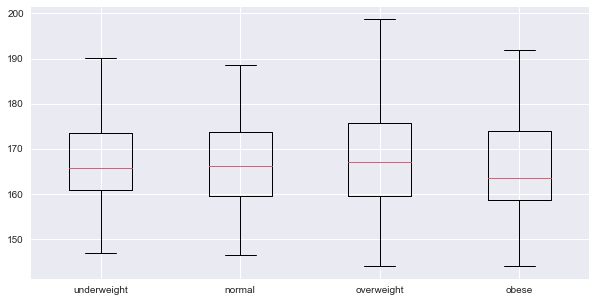

In [30]:
plt.figure(figsize=(10,5))
plt.boxplot(df_tmp)
plt.xticks(
    [y + 1 for y in range(df_tmp.shape[1])],
    labels=df_tmp.columns)
plt.show()

In [31]:
df_tmp_std = pd.DataFrame()

for col_name, df in a1:
    df_tmp_std[col_name] = standardize(df.height.reset_index(drop=True))

df_tmp_std

,underweight,normal,overweight,obese
0,-0.832466,1.775881,1.517954,-0.640698
1,1.299506,-0.918773,1.003151,1.844354
2,0.440191,-1.200304,-0.848160,-1.383243
3,-1.550374,0.840796,-0.570959,-0.531791
4,0.255275,-0.033961,-2.204469,0.111748
...,...,...,...,...
153,2.528652,1.242983,-0.957061,-0.363481
154,1.168977,-2.014733,-0.214556,-0.581294
155,0.168256,0.639703,-0.293757,2.151273
156,-0.353860,0.569320,1.141752,0.705785


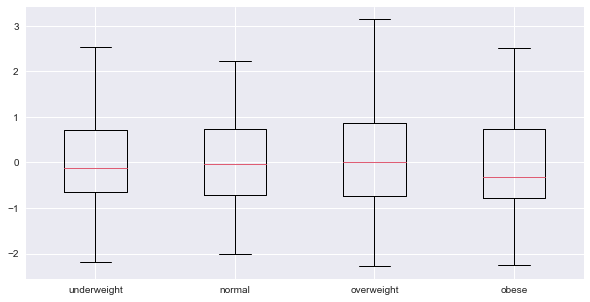

In [32]:
plt.figure(figsize=(10,5))
plt.boxplot(df_tmp_std)
plt.xticks(
    [y + 1 for y in range(df_tmp_std.shape[1])],
    labels=df_tmp_std.columns)
plt.show()

# Plotting by group

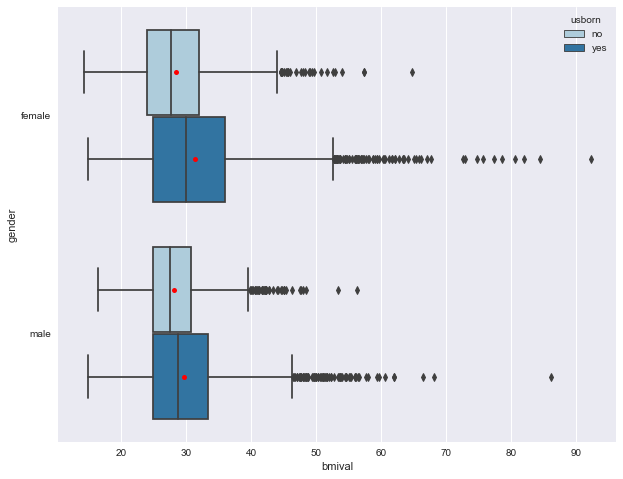

In [33]:
plt.figure(figsize=(10, 8))
q1 = sns.boxplot(x="bmival", y="gender", hue="usborn", data=nhanes, 
                 palette="Paired", showmeans=True,
                 meanprops={'marker':'o', 'markerfacecolor':'red', 'markersize':'5'})
plt.show()

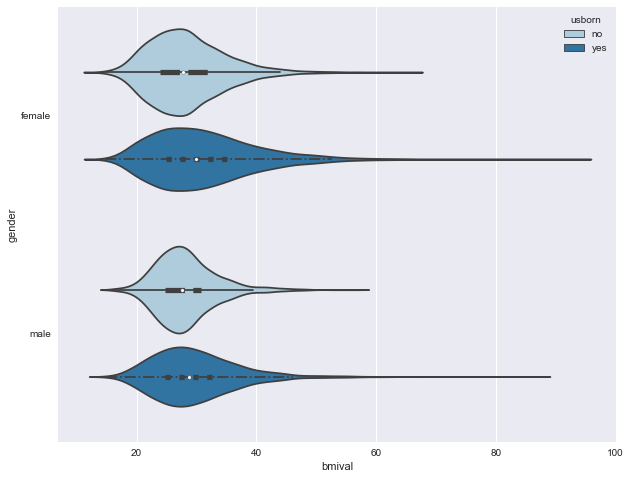

In [34]:
plt.figure(figsize=(10, 8))
sns.violinplot(x="bmival", y="gender", hue="usborn", data=nhanes, palette="Paired")
plt.show()

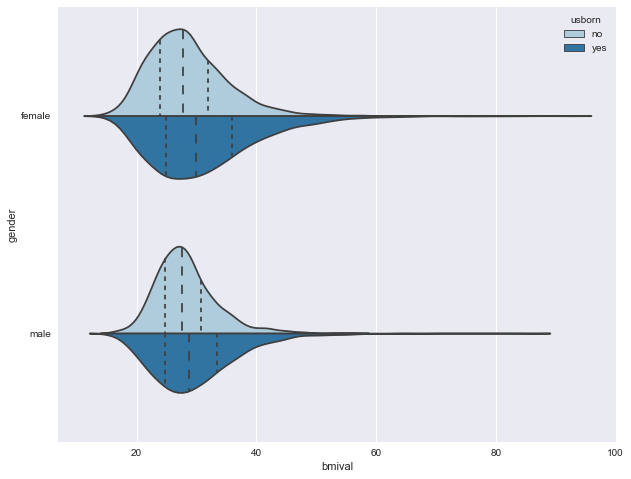

In [35]:
plt.figure(figsize=(10, 8))
sns.violinplot(x="bmival", y="gender", hue="usborn", data=nhanes,
               palette="Paired", split=True, inner="quart")
plt.show()

In [36]:
p1 = (
    nhanes
    .groupby(["gender", "bmicat"])
    .size()
    .rename("counts")
    .reset_index()
)

p1

,gender,bmicat,counts
0,female,underweight,93
1,female,normal,1161
2,female,overweight,1245
3,female,obese,2015
4,male,underweight,65
5,male,normal,1074
6,male,overweight,1513
7,male,obese,1619


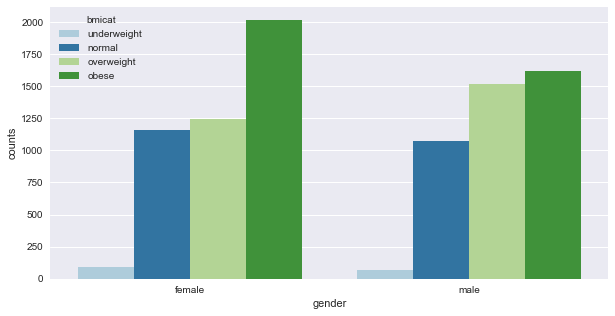

In [37]:
plt.figure(figsize=(10, 5))
sns.barplot(y="counts", x="gender", hue="bmicat", data=p1, palette="Paired")
plt.show()

In [38]:
p2 = (
    nhanes
    .loc[:, ["gender", "bmicat"]]
    .value_counts()
    .transform(lambda x: x / x.sum() * 100)
    .rename("percentage")
    .reset_index()
)

p2

,gender,bmicat,percentage
0,female,obese,22.936824
1,male,obese,18.429141
2,male,overweight,17.222538
3,female,overweight,14.171884
4,female,normal,13.215709
5,male,normal,12.225384
6,female,underweight,1.058623
7,male,underweight,0.739898


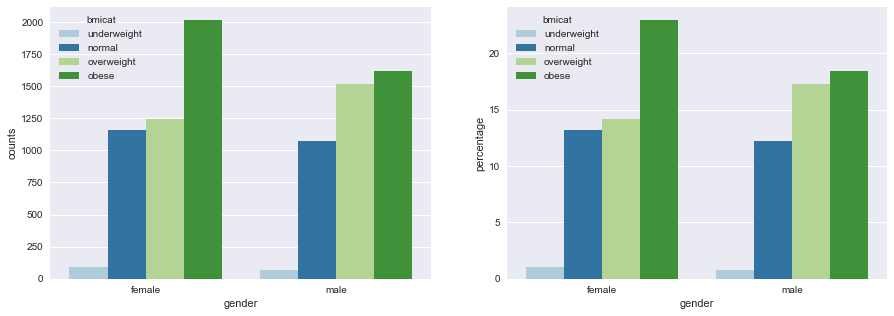

In [39]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
sns.barplot(y="counts", x="gender", hue="bmicat", data=p1, palette="Paired")

plt.subplot(122)
sns.barplot(y="percentage", x="gender", hue="bmicat", data=p2, palette="Paired")

plt.show()

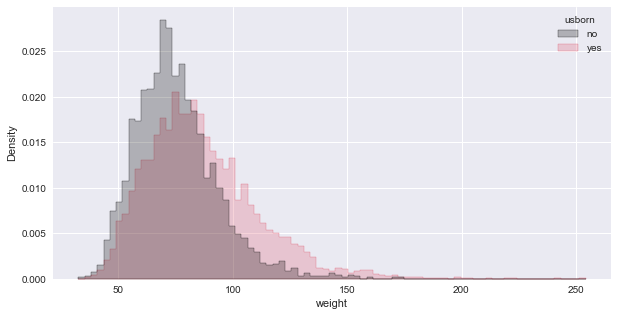

In [40]:
plt.figure(figsize=(10, 5))
sns.histplot(data=nhanes, x="weight", hue="usborn",
             element="step", stat="density", common_norm=False,
             )
plt.show()

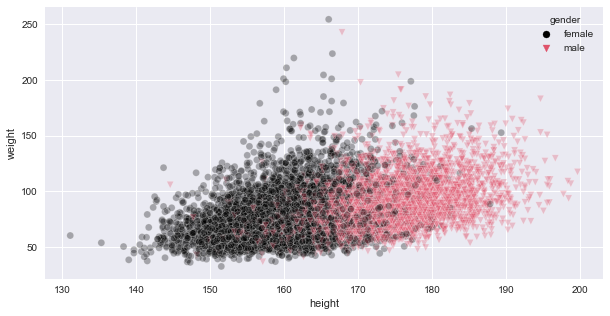

In [41]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=nhanes, x="height", y="weight", hue="gender",
                style="gender", alpha=0.3, markers=["o", "v"])
plt.show()

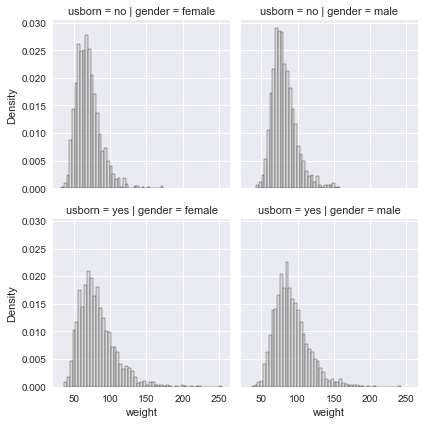

In [42]:
# plt.figure(figsize=(10, 5))
grid = sns.FacetGrid(nhanes, col="gender", row="usborn")
grid.map(sns.histplot, "weight", stat="density", color="lightgray")
plt.show()

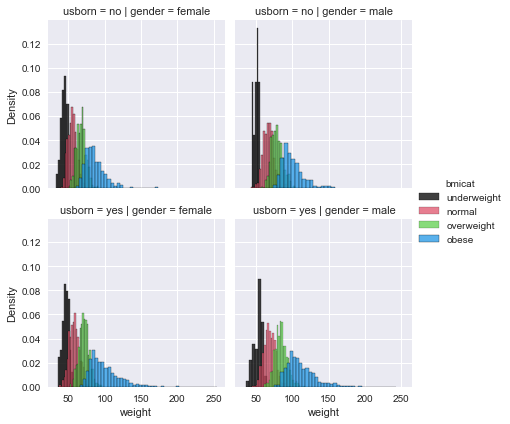

In [43]:
# plt.figure(figsize=(10, 5))
grid = sns.FacetGrid(nhanes, col="gender", row="usborn", hue="bmicat")
grid.map(sns.histplot, "weight", stat="density")
grid.add_legend()
plt.show()

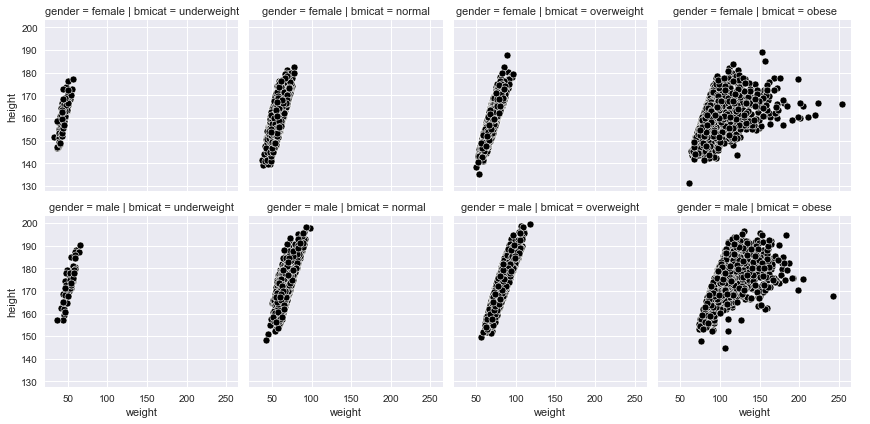

In [44]:
# plt.figure(figsize=(10, 5))
grid = sns.FacetGrid(nhanes, col="bmicat", row="gender")
grid.map(sns.scatterplot, "weight", "height")
grid.add_legend()
plt.show()

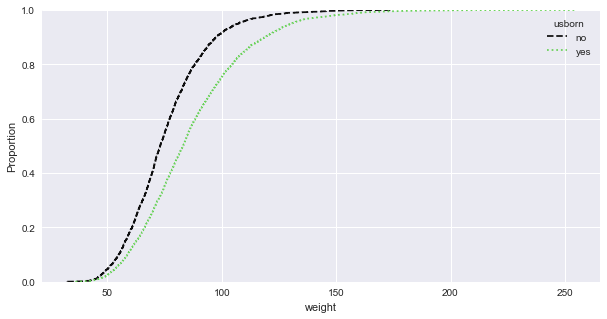

In [45]:
# Empirical cumulative distribution functions
plt.figure(figsize=(10, 5))
for usborn, weight in nhanes.groupby("usborn").weight:
    sns.ecdfplot(data=weight, label=usborn)
plt.legend(title="usborn")
plt.show()

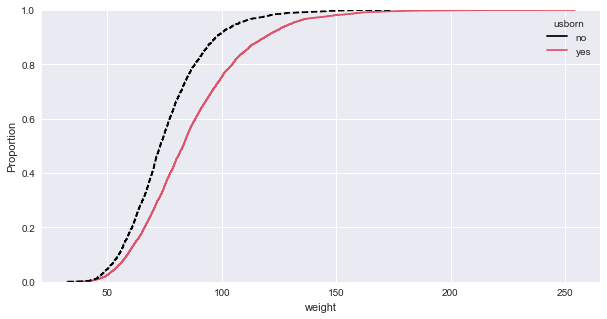

In [46]:
# Empirical cumulative distribution functions
plt.figure(figsize=(10, 5))
sns.ecdfplot(data=nhanes, x="weight", hue="usborn")
plt.show()

# 2-sample chi-squared test

Using the two-sample chi-squared test, verify whether the BMI category distributions
for men and women differ significantly from each other.

In [47]:
df1 = (
    nhanes
    .groupby(["gender", "bmicat"])
    .size()
    .rename("counts")
    .reset_index()
)

df1

,gender,bmicat,counts
0,female,underweight,93
1,female,normal,1161
2,female,overweight,1245
3,female,obese,2015
4,male,underweight,65
5,male,normal,1074
6,male,overweight,1513
7,male,obese,1619


In [48]:
ct1 = (
    df1
    .set_index(["gender", "bmicat"])
    .unstack()
    .loc[:, "counts"]
)

ct1

bmicat,underweight,normal,overweight,obese
gender,,,,
female,93,1161,1245,2015
male,65,1074,1513,1619


In [49]:
chisq, pvalue, df, expected = scipy.stats.chi2_contingency(ct1)
print(f"chisq: {chisq:.2f}")
print(f"pvalue: {pvalue}")
print(f"df: {df}")
print(f"expected:\n{np.round(expected, 1)}")

chisq: 70.88
pvalue: 2.771495569305468e-15
df: 3
expected:
[[  81.2 1148.4 1417.1 1867.3]
 [  76.8 1086.6 1340.9 1766.7]]


# Classification Tasks

## Load data (2)

In [50]:
wine_train = pd.read_csv("data/sweetwhitewine_train2.csv", comment="#")

print(f"Shape: {wine_train.shape}\n")
print(wine_train.head(5))

Shape: (1000, 3)

     alcohol      sugar  bad
0  10.625271  10.340159    0
1   9.066111  18.593274    1
2  10.806395   6.206685    0
3  13.432876   2.739529    0
4   9.578162   3.053025    0


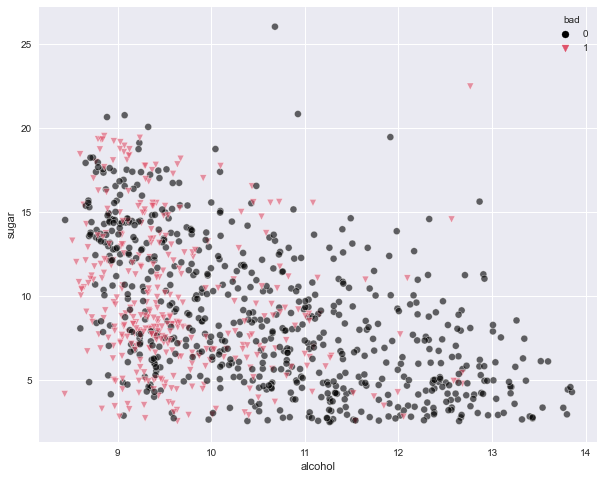

In [51]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=wine_train, x="alcohol", y="sugar", hue="bad",
                style="bad", markers=["o", "v"], alpha=0.6)
plt.show()

In [52]:
wine_test = pd.read_csv("data/sweetwhitewine_test2.csv", comment="#")

print(f"Shape: {wine_test.shape}\n")
print(wine_test.head(5))

Shape: (500, 3)

     alcohol      sugar  bad
0   9.315523  10.041971    1
1  12.909232   6.814249    0
2   9.051020  12.818683    0
3   9.567601  11.091827    1
4   9.494031  12.053790    0


## K-Nearest Neighbour

In [53]:
X_train = np.array(wine_train.loc[:, ["alcohol", "sugar"]])
means = np.mean(X_train, axis=0)
sds  = np.std(X_train, axis=0)
Z_train = (X_train-means)/sds # z-scores for training set
Z_train[:5, :]

array([[ 0.27965338,  0.28261684],
       [-0.95115759,  2.19541229],
       [ 0.42263361, -0.67538377],
       [ 2.4959955 , -1.47895435],
       [-0.5469415 , -1.40629647]])

In [54]:
y_train = np.array(wine_train.bad)
y_train[:5]

array([0, 1, 0, 0, 0], dtype=int64)

In [55]:
 # z-scores for test set
Z_test = (np.array(wine_test.loc[:, ["alcohol", "sugar"]])-means) / sds
Z_test[:5, :]

array([[-0.75427058,  0.21350697],
       [ 2.08262702, -0.53457094],
       [-0.96307108,  0.85705578],
       [-0.55527821,  0.4568283 ],
       [-0.61335491,  0.67977913]])

In [56]:
y_test = np.array(wine_test.bad)
y_test[:5]

array([1, 0, 0, 1, 0], dtype=int64)

In [57]:
k = 5
knn = KNeighborsClassifier()
knn.fit(Z_train, y_train)
y_pred = knn.predict(Z_test)

In [58]:
# accuracy
np.mean(y_pred == y_test)

0.706

In [59]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[272,  58],
       [ 89,  81]], dtype=int64)

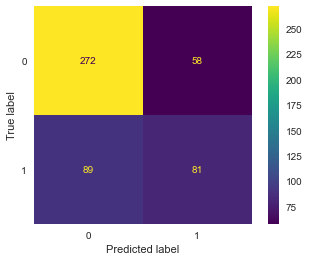

In [60]:
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.grid(False)
plt.show()